# 任务2 数据清洗(2天)
每一步都要认真完成，附上代码，最终效果截图

## 缺失值分析及处理

* 缺失值出现的原因分析
* 采取合适的方式对缺失值进行填充

## 异常值分析及处理

* 根据测试集数据的分布处理训练集的数据分布

* 使用合适的方法找出异常值
* 对异常值进行处理

## 深度清洗

* 分析每一个communityName、city、region、plate的数据分布并对其进行数据清洗





## 简要分析
在任务一中，我们对于赛题、数据总体情况、缺失值、特征分布等信息做了简要的分析。在本次任务中就是基于任务一的分析做数据清理工作。  
在一些场景中，任务一和任务二合并起来会被称作EDA(Exploratory Data Analysis-探索性数据分析)。当然真正的EDA包含的内容远不止这两份参考示例所展示了，大家可以自行学习尝试。  
  



参考资料：   
[一文带你探索性数据分析(EDA)
](https://www.jianshu.com/p/9325c9f88ee6)

# 缺失值处理

In [29]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

# GBDT
from sklearn.ensemble import GradientBoostingRegressor
# XGBoost
import xgboost as xgb
# LightGBM
import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import pickle
import multiprocessing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression,LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import copy

In [36]:
#载入数据
data_train = pd.read_csv('数据集/train_data.csv')
data_train['Type'] = 'Train'
data_test = pd.read_csv('数据集/test_a.csv')
data_test['Type'] = 'Test'
data_all = pd.concat([data_train, data_test], ignore_index=True)
data = copy.deepcopy(data_train)

## 主要思路分析
虽然这步骤是缺失值处理，但还会涉及到一些最最基础的数据处理。  
1. **缺失值处理**  
缺失值的处理手段大体可以分为：删除、填充、映射到高维(当做类别处理)。  
详细的请自行查找相关资料学习。  
根据任务一，直接找到的缺失值情况是pu和pv；但是，根据特征nunique分布的分析，可以发现rentType存在"--"的情况，这也算是一种缺失值。  
此外，诸如rentType的"未知方式"；houseToward的"暂无数据"等，本质上也算是一种缺失值，但是对于这些缺失方式，我们可以把它当做是特殊的一类处理，而不需要去主动修改或填充值。  
  
  将rentType的"--"转换成"未知方式"类别；  
  pv/pu的缺失值用均值填充；  
  buildYear存在"暂无信息"，将其用众数填充。  
  
    
2. **转换object类型数据**  
这里直接采用LabelEncoder的方式编码，详细的编码方式请自行查阅相关资料学习。  
  
  
3. **时间字段的处理**  
buildYear由于存在"暂无信息",所以需要主动将其转换int类型；  
tradeTime，将其分割成月和日。  
  
  
4. **删除无关字段**  
ID是唯一码，建模无用，所以直接删除；  
city只有一个SH值，也直接删除；  
tradeTime已经分割成月和日，删除原来字段

In [32]:
def preprocessingData(data):
    # 填充缺失值
    # 有两种缺失值：-- 和 未知方式 
    # 把 -- 转换为 未知方式 然后使用 labelEncoder 编码
    data['rentType'][data['rentType'] == '--'] = '未知方式'
    
    # 转换object类型数据
    columns = ['rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
    
    for feature in columns:
        le = LabelEncoder()
        data[feature] = le.fit_transform(data[feature])
        print(le.classes_)

    # 将buildYear列转换为整型数据
    # 缺失值是 暂无信息
    # 取非缺失值，计算buildYear的众数： 1994
    # buildYearmean.iloc[0, 0] 是取这个serise的值
    buildYearmean = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
    # data[data['buildYear'] != '暂无信息']['buildYear'] 这种方式也可以赋值
    data.loc[data[data['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearmean.iloc[0, 0]
    # 改变buildYear类型 buildYear最开始是object类型，现在需要转换为int类型
    data['buildYear'] = data['buildYear'].astype('int')

    # 处理pv和uv的空值
    # 使用平均值填充
    data['pv'].fillna(data['pv'].mean(), inplace=True)
    data['uv'].fillna(data['uv'].mean(), inplace=True)
    # pv和uv是float类型，根据实际经验这里转为int类型
    data['pv'] = data['pv'].astype('int')
    data['uv'] = data['uv'].astype('int')

    # 分割交易时间tradeTime
    # 没有缺失值，可以直接处理
    # 全部是2008年所以不用分割年
    # 分割出月和日即可
    def month(x):
        month = int(x.split('/')[1])
        return month
    def day(x):
        day = int(x.split('/')[2])
        return day
    data['month'] = data['tradeTime'].apply(lambda x: month(x))
    data['day'] = data['tradeTime'].apply(lambda x: day(x))
    
    # 去掉部分特征
    data.drop('city', axis=1, inplace=True)
    data.drop('tradeTime', axis=1, inplace=True)
    data.drop('ID', axis=1, inplace=True)
    return data

data = copy.deepcopy(data_train)
data = preprocessingData(data)

data.head()

['合租' '整租' '未知方式']
['XQ00001' 'XQ00002' 'XQ00003' ... 'XQ04234' 'XQ04235' 'XQ04236']
['0室0厅1卫' '1室0厅0卫' '1室0厅1卫' '1室1厅0卫' '1室1厅1卫' '1室1厅2卫' '1室2厅1卫' '1室2厅2卫'
 '2室0厅0卫' '2室0厅1卫' '2室0厅2卫' '2室1厅0卫' '2室1厅1卫' '2室1厅2卫' '2室1厅3卫' '2室2厅0卫'
 '2室2厅1卫' '2室2厅2卫' '2室2厅3卫' '2室3厅1卫' '3室0厅0卫' '3室0厅1卫' '3室0厅2卫' '3室1厅0卫'
 '3室1厅1卫' '3室1厅2卫' '3室1厅3卫' '3室2厅1卫' '3室2厅2卫' '3室2厅3卫' '3室2厅4卫' '3室2厅5卫'
 '3室3厅2卫' '3室3厅3卫' '3室3厅4卫' '3室4厅4卫' '4室0厅1卫' '4室0厅2卫' '4室0厅4卫' '4室1厅1卫'
 '4室1厅2卫' '4室1厅3卫' '4室1厅4卫' '4室2厅1卫' '4室2厅2卫' '4室2厅3卫' '4室2厅4卫' '4室2厅5卫'
 '4室3厅2卫' '4室3厅3卫' '4室3厅4卫' '4室3厅5卫' '4室4厅2卫' '5室1厅1卫' '5室1厅2卫' '5室1厅3卫'
 '5室1厅5卫' '5室2厅1卫' '5室2厅2卫' '5室2厅3卫' '5室2厅4卫' '5室2厅5卫' '5室2厅6卫' '5室3厅1卫'
 '5室3厅2卫' '5室3厅3卫' '5室3厅4卫' '5室3厅5卫' '5室3厅6卫' '5室4厅2卫' '5室4厅3卫' '5室4厅4卫'
 '5室4厅5卫' '5室5厅4卫' '6室1厅1卫' '6室1厅4卫' '6室2厅1卫' '6室2厅2卫' '6室2厅3卫' '6室2厅4卫'
 '6室2厅5卫' '6室2厅6卫' '6室2厅7卫' '6室3厅2卫' '6室3厅3卫' '6室3厅4卫' '6室3厅5卫' '6室4厅2卫'
 '6室4厅4卫' '6室4厅5卫' '7室1厅1卫' '7室1厅3卫' '7室1厅7卫' '7室2厅1卫' '7室2厅3卫' '7室2厅4卫'
 '7室3厅4卫' '7室4厅3卫' '8室2厅3卫' '8室2厅4卫' '8

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,2,12,1,16,6,0,50,0,63,...,28248,614,111546,1124,284,0,2000.0,Train,11,28
1,125.55,2,28,0,14,6,2,129,1,48,...,14823,148,157552,701,22,1,2000.0,Train,12,16
2,132.00,2,28,1,32,6,0,178,1,49,...,77645,520,131744,57,20,1,16000.0,Train,12,22
3,57.00,2,4,0,17,6,3,312,1,50,...,8750,1665,253337,888,279,9,1600.0,Train,12,21
4,129.00,2,29,1,2,6,1,1256,2,43,...,800,117,125309,2038,480,0,2900.0,Train,11,18


In [39]:
data.groupby("rentType")["rentType"].count()

rentType
--          5
合租       5204
整租       5472
未知方式    30759
Name: rentType, dtype: int64

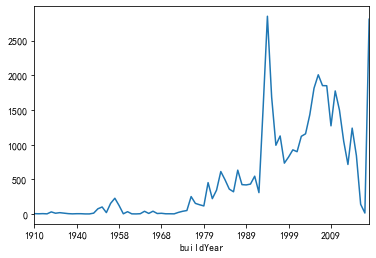

In [48]:
data.groupby("buildYear")["buildYear"].count().plot()

In [47]:
result = data[data['buildYear'] != '暂无信息']['buildYear'].mode()
print(type(result))
print(result.dtypes)
result

<class 'pandas.core.series.Series'>
object


0    1994
dtype: object

In [60]:
data.loc[data['buildYear'] == '暂无信息', 'buildYear'].count()

2808

In [58]:
data_train.dtypes

ID                      int64
area                  float64
rentType               object
houseType              object
houseFloor             object
totalFloor              int64
houseToward            object
houseDecoration        object
communityName          object
city                   object
region                 object
plate                  object
buildYear              object
saleSecHouseNum         int64
subwayStationNum        int64
busStationNum           int64
interSchoolNum          int64
schoolNum               int64
privateSchoolNum        int64
hospitalNum             int64
drugStoreNum            int64
gymNum                  int64
bankNum                 int64
shopNum                 int64
parkNum                 int64
mallNum                 int64
superMarketNum          int64
totalTradeMoney         int64
totalTradeArea        float64
tradeMeanPrice        float64
tradeSecNum             int64
totalNewTradeMoney      int64
totalNewTradeArea       int64
tradeNewMe

# 异常值处理

## 主要思路分析
这里主要针对area和tradeMoney两个维度处理。  
针对tradeMoney，这里采用的是IsolationForest模型自动处理；  
针对area hetotalFloor是主观+数据可视化的方式得到的结果。

参考资料：  
[iForest （Isolation Forest）孤立森林 异常检测 入门篇](https://zhuanlan.zhihu.com/p/25040651)


In [4]:
# clean data
def IF_drop(train):
    # 孤立森林模型
    IForest = IsolationForest(contamination=0.01)
    IForest.fit(train["tradeMoney"].values.reshape(-1,1))
    y_pred = IForest.predict(train["tradeMoney"].values.reshape(-1,1))
    drop_index = train.loc[y_pred==-1].index
    print(drop_index)
    train.drop(drop_index,inplace=True)
    return train

data_train = IF_drop(data_train)

/Users/nick/.venv/ML-training/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Int64Index([   62,    69,   128,   131,   246,   261,   266,   297,   308,
              313,
            ...
            39224, 39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083,
            41233],
           dtype='int64', length=403)


In [5]:
def dropData(train):
    # 丢弃部分异常值
    train = train[train.area <= 200]
    train = train[(train.tradeMoney <=16000) & (train.tradeMoney >=700)]
    train.drop(train[(train['totalFloor'] == 0)].index, inplace=True)
    return train  
#数据集异常值处理
data_train = dropData(data_train)

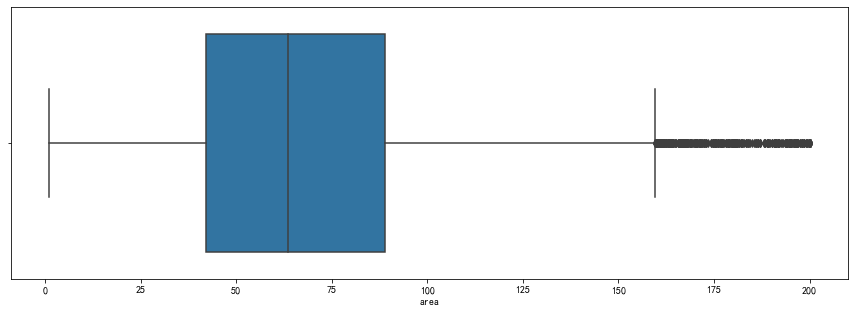

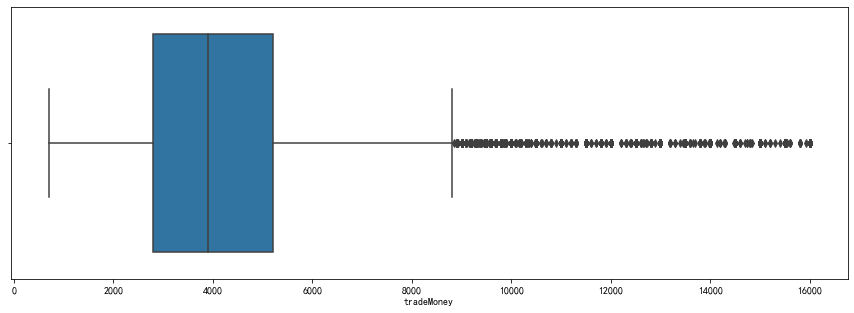

In [6]:
# 处理异常值后再次查看面积和租金分布图
plt.figure(figsize=(15,5))
sns.boxplot(data_train.area)
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data_train.tradeMoney),
plt.show()

# 深度清洗

## 主要思路分析
针对每一个region的数据，对area和tradeMoney两个维度进行深度清洗。 
采用主观+数据可视化的方式。

In [7]:
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

data_train = cleanData(data_train)